In [1]:
import os
import re
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from transformers import AutoTokenizer, TFBertModel, BertTokenizer
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, confusion_matrix , accuracy_score , classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.utils import shuffle
import platform
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Input, MaxPooling1D, Dropout, Flatten, LSTM, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import backend as K
from keras import regularizers
seed=2023
import pickle

In [2]:
pd.set_option('display.max_columns',100)

In [51]:
plt.rcParams.update({'font.family': 'times new roman', 'font.size': 25})

In [80]:
def count_freq(col, counts):

    df3 = df2.copy()
    col_name = col

    col_nameNew = col_name+"_length"
    df3[col_nameNew] = counts
    text_counts = df3[col_nameNew].value_counts().sort_index()
    text_counts = text_counts[text_counts.index!=0]

    text_freq = text_counts / text_counts.sum()
    cumulative_freq = np.cumsum(text_freq)

    fig, ax = plt.subplots(figsize=(7.5, 4.5))

    ax.plot(text_counts.index, cumulative_freq, 'b--', label='Cumulative Frequency')

    x0 = np.min(text_counts[~(cumulative_freq < 0.99)].index)
    y0 = cumulative_freq[x0]
#     ax.annotate(f'({x0}, {0.99})', xy=(x0, y0), xycoords='data', xytext=(30, -30), textcoords='offset points',
#                 fontsize=12, arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-.3'))

    x1 = np.min(text_counts[~(cumulative_freq < 0.95)].index)
    y1 = cumulative_freq[x1]
    ax.annotate(f'({x1}, {0.95})', xy=(x1, y1), xycoords='data', xytext=(30, -30), textcoords='offset points',
                fontsize=20, arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.3'))
    
    x2 = np.min(text_counts[~(cumulative_freq < 0.9)].index)
    y2 = cumulative_freq[x2]
#     ax.annotate(f'({x2}, {0.9})', xy=(x2, y2), xycoords='data', xytext=(30, -30), textcoords='offset points',
#                 fontsize=12, arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.3'))

#     ax.plot([x0, x0], [y0, 0], 'k--', lw=1)
#     ax.plot([0, x0], [y0, y0], 'k--', lw=1)
    
    ax.plot([x1, x1], [y1, 0], 'k--', lw=1)
    ax.plot([0, x1], [y1, y1], 'k--', lw=1)
    
#     ax.plot([x2, x2], [y2, 0], 'k--', lw=1)
#     ax.plot([0, x2], [y2, y2], 'k--', lw=1)

    ax.set_xlabel('Token Count', fontsize=23)
    ax.set_ylabel('Value', fontsize=23)

#     ax.tick_params(axis='both', labelsize=12)
    ax.tick_params(axis='x', labelsize=23)
    ax.tick_params(axis='y', labelsize=23)

    ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

#     ax.set_title('The cumulative frequency of the number of tokens in '+ col_name , fontsize=14, fontweight='bold')
#     ax.set_title(col_name , fontsize=14, fontweight='bold')
    if col_name=="icd_title":
        ax.set_title("ICD" , fontsize=23)
    else:
        ax.set_title(col_name , fontsize=23)

    ax.legend(loc='lower right', fontsize=20)

    ax.set_xlim(0, )  # max(text_counts.index)
    ax.set_ylim(0, )  # 1

    plt.tight_layout()

    path = os.path.join("E:/CNSI_project/demo_and_data_5.0/figure_in_paper/aim2/tokens", f"{col}.tif")
    plt.savefig(path, dpi=300, bbox_inches='tight')

    # plt.savefig('text_length_cumulative_freq.png', dpi=300)
    print(f"最长的tokens为{max(text_counts.index)}个词汇或单词。")

    plt.show()
    return x0,x1,x2

In [4]:
# If words and punctuation marks are joined together, put a space between them.
def add_space_around_punctuation(texts):
    texts = [text.lower() for text in texts]
    
    # Create a character set that contains all the specified punctuation marks
    punctuation_chars = r'!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'
    
    # Compile a regular expression pattern that matches places where spaces need to be added
    # Handle cases where there is no space before a punctuation mark
    pattern_before = re.compile(r'(?<!\s)([' + re.escape(punctuation_chars) + r'])')
    # Handles punctuation without a space after it, but does not match punctuation at the end of a string
    pattern_after = re.compile(r'([' + re.escape(punctuation_chars) + r'])(?!\s|$)')
    
    # Use regular expression patterns to add spaces
    texts_with_spaces = [pattern_before.sub(r' \1', text) for text in texts]
    texts_with_spaces = [pattern_after.sub(r'\1 ', text) for text in texts_with_spaces]
    
    # Dispose of redundant spaces and ensure that there is only one space before and after punctuation marks
    texts_with_single_spaces = [re.sub(r'\s+', ' ', text) for text in texts_with_spaces]

    return texts_with_single_spaces

In [5]:
# List of example texts
texts = ["Hello,world!", "Good morning, Dr. John.", "Isn't this fun?Yes!",'fever/ms changes, con']

# Call the function and print the result
texts_with_spaces = add_space_around_punctuation(texts)
print(texts_with_spaces)

['hello , world !', 'good morning , dr . john .', "isn't this fun ? yes !", 'fever / ms changes , con']


In [6]:
df2 = pd.read_csv("E:/CNSI_project/demo_and_data_5.0/Processed_data/MIMIC/aim2_dataAll_filtered.csv")
df2

,subject_id,hadm_id,chartdate,Chemistry~Blood~Albumin~50862~g/dL,Chemistry~Blood~Alkaline Phosphatase~50863~IU/L,"Chemistry~Blood~Calcium, Total~50893~mg/dL",Chemistry~Blood~Chloride~50902~mEq/L,Chemistry~Blood~Lactate Dehydrogenase (LD)~50954~IU/L,Chemistry~Blood~Phosphate~50970~mg/dL,Chemistry~Blood~Urea Nitrogen~51006~mg/dL,Hematology~Blood~Eosinophils~51200~%,Hematology~Blood~INR(PT)~51237~,Hematology~Blood~MCV~51250~fL,Hematology~Blood~Platelet Count~51265~K/uL,Hematology~Blood~PT~51274~sec,Hematology~Blood~RDW~51277~%,Hematology~Blood~Red Blood Cells~51279~m/uL,Hematology~Blood~White Blood Cells~51301~K/uL,"Chemistry~Cerebrospinal Fluid~Lactate Dehydrogenase, CSF~51795~IU/L","Chemistry~Cerebrospinal Fluid~Total Protein, CSF~51802~mg/dL",Hematology~Cerebrospinal Fluid~Eosinophils~52256~%,Hematology~Cerebrospinal Fluid~Polys~52281~%,"Hematology~Cerebrospinal Fluid~RBC, CSF~52285~#/uL",age,resprate,acuity,Chief Complaint,icd_title,History of Present Illness,Past Medical History,Allergies,Family History,hospital_expire_flag
0,10001217,24597018.0,2157-11-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,NaN,0.0,5.0,55,16.0,3.0,"LEFT HAND PAINS, Left hand and face numbness, ...",Cerebral edema; Compression of brain; Family h...,Mrs. ___ is a ___ y/o F from ___ with history ...,Multiple sclerosis,Penicillins,"Mother with pancreatic cancer, brother-lung ca...",0
1,10003019,21616816.0,2174-09-18,2.6,NaN,10.4,102.0,NaN,2.8,32.0,NaN,NaN,78.0,557.0,NaN,18.3,4.04,16.6,NaN,75.0,NaN,10.0,430.0,72,16.0,2.0,"FEVER/MS CHANGES, confusion, rehab placement","Acute kidney failure, unspecified; Asthma, uns...","___ male w/ PMH of sarcoidosis, sleep apnea, n...","1. Sarcoidosis, dx skin bx:intestinal & pulmon...",Oxycodone / Ragweed,"Mother:___, cardiac disease. Father:diverticul...",0
2,10005808,26543907.0,2119-01-02,NaN,48.0,9.3,105.0,NaN,2.5,18.0,3.2,NaN,87.0,256.0,NaN,13.9,5.03,9.8,NaN,72.0,NaN,0.0,510.0,53,NaN,NaN,limb weakness and tingling,Acute infective polyneuritis,Mr. ___ is a ___ year old right handed gentlem...,Hiatal hernia in ___ Occasional heartburn,No Known Allergies / Adverse Drug Reactions,He has no family history of autoimmune disease...,0
3,10006269,27357430.0,2124-06-26,4.9,80.0,NaN,95.0,NaN,NaN,15.0,0.0,NaN,66.0,225.0,NaN,20.1,4.66,10.0,NaN,100.0,NaN,1.0,2.0,51,19.0,3.0,"Fever, Headache",Duodenitis without bleeding; Essential (primar...,NaN,NaN,No Known Allergies / Adverse Drug Reactions,NaN,0
4,10014078,25809882.0,2166-08-22,NaN,NaN,8.1,117.0,NaN,2.8,7.0,NaN,NaN,76.0,201.0,NaN,13.7,4.32,6.9,NaN,75.0,NaN,27.0,1.0,60,NaN,NaN,seizure,Benign neoplasm of cerebral meninges; Diabetes...,The pt is a ___ year-old woman who presents as...,hx of atypical meningioma - grade 2 - resected...,No Known Allergies / Adverse Drug Reactions,noncontributory,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5790,19994772,29219051.0,2181-04-18,NaN,NaN,NaN,103.0,150.0,NaN,9.0,0.3,NaN,92.0,325.0,NaN,12.7,4.02,10.7,NaN,244.0,NaN,88.0,0.0,55,20.0,2.0,Aletered mental status and fever,Abnormal involuntary movements; Candidiasis of...,___ is a ___ woman with,PAST MEDICAL HISTORY:Recurrent glioblastoma in...,Keflex,Non-contributory.,0
5791,19994772,29606061.0,2180-12-18,NaN,NaN,9.7,103.0,NaN,3.3,16.0,0.2,NaN,93.0,257.0,NaN,12.4,3.46,7.2,NaN,295.0,NaN,100.0,5100.0,54,NaN,NaN,Recurrent glioblastoma.,"Cerebral aneurysm, nonruptured; Compression of...",Ms. ___ is a ___ y/o F s/p resection of gliobl...,Hyperlipidemia,___,non-contributory,0
5792,19995080,23057109.0,2147-07-13,2.3,961.0,7.5,105.0,NaN,2.3,17.0,0.3,1.1,94.0,377.0,12.7,15.7,3.52,3.8,NaN,44.0,NaN,8.0,1.0,59,NaN,NaN,Confusion- Altered Mental Status- transfer fro...,Calculus of gallbladder and bile duct without ...,___ M with AIDS and med non-compliance (CD4 20...,"- AIDS off ART prescribed for Truvada T qd, Ka...",Penicillins,Father died of AD at age ___. Mother died of D...,0
5793,1999978

In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5795 entries, 0 to 5794
Data columns (total 33 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   subject_id                                                           5795 non-null   int64  
 1   hadm_id                                                              5795 non-null   float64
 2   chartdate                                                            5795 non-null   object 
 3   Chemistry~Blood~Albumin~50862~g/dL                                   1486 non-null   float64
 4   Chemistry~Blood~Alkaline Phosphatase~50863~IU/L                      2241 non-null   float64
 5   Chemistry~Blood~Calcium, Total~50893~mg/dL                           3966 non-null   float64
 6   Chemistry~Blood~Chloride~50902~mEq/L                                 4992 non-null   float64
 7   Chemis

In [8]:
df2.hospital_expire_flag.value_counts()

0    5500
1     295
Name: hospital_expire_flag, dtype: int64

In [94]:
plt.rcParams.update({'font.family': 'times new roman', 'font.size': 25})

文本Family History最长26333，总长度为1277495，平均为220.44779982743745


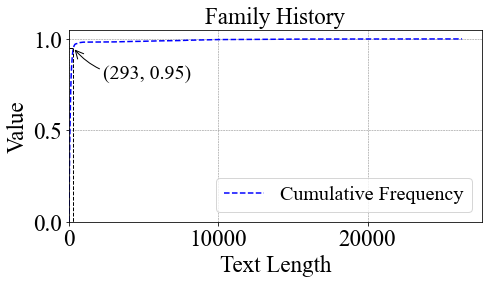

In [109]:
df3 = df2.copy()
col_name = 'Family History'

col_nameNew = col_name+"_length"
df3[col_nameNew] = df3[col_name].apply(lambda x: len(x) if not pd.isnull(x) else 0)
text_counts = df3[col_nameNew].value_counts().sort_index()
text_counts1 = text_counts.copy()
text_counts = text_counts[text_counts.index!=0]

text_freq = text_counts / text_counts.sum()
cumulative_freq = np.cumsum(text_freq)

fig, ax = plt.subplots(figsize=(7.5, 4.5))

ax.plot(text_counts.index, cumulative_freq, 'b--', label='Cumulative Frequency')

x0 = np.min(text_counts[~(cumulative_freq < 0.95)].index)
y0 = cumulative_freq[x0]
ax.annotate(f'({x0}, {round(y0, 3)})', xy=(x0, y0), xycoords='data', xytext=(30, -30), textcoords='offset points',
            fontsize=20, arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-.3'))

ax.plot([x0, x0], [y0, 0], 'k--', lw=1)
ax.plot([0, x0], [y0, y0], 'k--', lw=1)

ax.set_xlabel('Text Length', fontsize=23)
ax.set_ylabel('Value', fontsize=23)

ax.tick_params(axis='both', labelsize=23)

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

# ax.set_title('The cumulative frequency of the text length of '+ col_name , fontsize=14, fontweight='bold')
if col_name=="icd_title":
    ax.set_title("ICD" , fontsize=23)
else:
    ax.set_title(col_name , fontsize=23)

ax.legend(loc='lower right', fontsize=20)

ax.set_xlim(0, )  # max(text_counts.index)
ax.set_ylim(0, )  # 1

plt.tight_layout()

path = os.path.join("E:/CNSI_project/demo_and_data_5.0/figure_in_paper/aim2/text_length", f"{col_name}.tif")
plt.savefig(path, dpi=300, bbox_inches='tight')

# plt.savefig('text_length_cumulative_freq.png', dpi=300)
print(f"文本{col_name}最长{max(text_counts1.index)}，总长度为{df3[col_nameNew].sum()}，平均为{df3[col_nameNew].mean()}")
plt.show()

In [10]:
df2.columns

Index(['subject_id', 'hadm_id', 'chartdate',
       'Chemistry~Blood~Albumin~50862~g/dL',
       'Chemistry~Blood~Alkaline Phosphatase~50863~IU/L',
       'Chemistry~Blood~Calcium, Total~50893~mg/dL',
       'Chemistry~Blood~Chloride~50902~mEq/L',
       'Chemistry~Blood~Lactate Dehydrogenase (LD)~50954~IU/L',
       'Chemistry~Blood~Phosphate~50970~mg/dL',
       'Chemistry~Blood~Urea Nitrogen~51006~mg/dL',
       'Hematology~Blood~Eosinophils~51200~%',
       'Hematology~Blood~INR(PT)~51237~', 'Hematology~Blood~MCV~51250~fL',
       'Hematology~Blood~Platelet Count~51265~K/uL',
       'Hematology~Blood~PT~51274~sec', 'Hematology~Blood~RDW~51277~%',
       'Hematology~Blood~Red Blood Cells~51279~m/uL',
       'Hematology~Blood~White Blood Cells~51301~K/uL',
       'Chemistry~Cerebrospinal Fluid~Lactate Dehydrogenase, CSF~51795~IU/L',
       'Chemistry~Cerebrospinal Fluid~Total Protein, CSF~51802~mg/dL',
       'Hematology~Cerebrospinal Fluid~Eosinophils~52256~%',
       'Hematology~Ce

In [13]:
# Load ClinicalBERT tokenizer and model
pretrained_model = 'G:/BertModels/BioBERT'
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
model = TFBertModel.from_pretrained(pretrained_model, from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

# 1. word2vec: ChiefComplaint_combined

In [48]:
# 1 Prepare word2vec for the general case
col = "Chief Complaint"
sentences_maxlength = 1398   # In the most extreme case, it's one token per character #

In [49]:
sentences = df2[col].fillna("").values.tolist()
encoding = tokenizer(sentences, 
                     add_special_tokens=False, 
                     return_tensors='tf', 
                     padding='max_length', 
                     truncation=True, 
                     max_length=sentences_maxlength)

input_ids = encoding['input_ids']
input_ids1 = input_ids.numpy()
print(input_ids1.shape)
input_ids1

(5795, 1398)


array([[ 1286,  1289, 24782, ...,     0,     0,     0],
       [10880,   120,   182, ...,     0,     0,     0],
       [16864, 11477,  1105, ...,     0,     0,     0],
       ...,
       [ 6406,   118,  8599, ...,     0,     0,     0],
       [22832,   182,  2047, ...,     0,     0,     0],
       [  181,  3420, 11477, ...,     0,     0,     0]])

最长的tokens为362个词汇或单词。


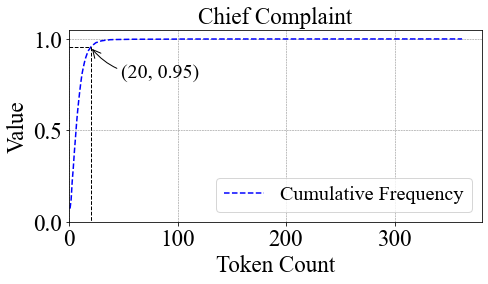

In [76]:
# Count the number of non-zero values in each row, i.e. the number converted to tokens. Then do the frequency accumulation graph
counts = np.count_nonzero(input_ids1, axis=1)
x0,x1,x2 = count_freq(col, counts)

In [33]:
input_ids1_cumF99 = input_ids1[:,:x0]
print(input_ids1_cumF99.shape)
input_ids1_cumF99

(5794, 31)


array([[ 1260,  7889,  7412, ...,     0,     0,     0],
       [ 4036,   117, 21718, ...,     0,     0,     0],
       [16320,   117,  5173, ...,     0,     0,     0],
       ...,
       [10880,   117, 11477, ...,     0,     0,     0],
       [20752,   119,     0, ...,     0,     0,     0],
       [  170,  8178,  1126, ...,     0,     0,     0]])

In [34]:
input_ids1_cumF95 = input_ids1[:,:x1]
print(input_ids1_cumF95.shape)
input_ids1_cumF95

(5794, 20)


array([[ 1260,  7889,  7412, ...,   119,     0,     0],
       [ 4036,   117, 21718, ...,     0,     0,     0],
       [16320,   117,  5173, ...,     0,     0,     0],
       ...,
       [10880,   117, 11477, ...,     0,     0,     0],
       [20752,   119,     0, ...,     0,     0,     0],
       [  170,  8178,  1126, ...,     0,     0,     0]])

In [35]:
input_ids1_cumF90 = input_ids1[:,:x2]
print(input_ids1_cumF90.shape)
input_ids1_cumF90

(5794, 16)


array([[ 1260,  7889,  7412, ...,  2765,  1610, 16430],
       [ 4036,   117, 21718, ...,     0,     0,     0],
       [16320,   117,  5173, ...,     0,     0,     0],
       ...,
       [10880,   117, 11477, ..., 13200, 23610,     0],
       [20752,   119,     0, ...,     0,     0,     0],
       [  170,  8178,  1126, ...,     0,     0,     0]])

In [48]:
# 2 Preparing word2vec for the LSTM

In [36]:
texts = df2[col].fillna("").values.tolist()
texts = add_space_around_punctuation(texts)
# Create an empty collection to store unique words in the text
unique_words = set()

# Traverse the text list
for text in texts:
    # Use str.split() to split spaces by default
    words = text.split()
    # Add words to a collection, automatically de-duplicated
    unique_words.update(words)

# Count the number of different words
unique_word_count = len(unique_words)
print(f'There are {unique_word_count} unique words in the texts.')

There are 2293 unique words in the texts.


In [37]:
# Text pre-processing
max_fatures = int(unique_word_count*1)
# filters = '!"#$%&()*+.,-/:;<=>?@[\\]^_`{|}~\t\n' 
tokenizer1 = Tokenizer(num_words=max_fatures, filters='', split=' ')
tokenizer1.fit_on_texts(texts)

# Save tokenizer1 for subsequent continuation of similar data processing
with open('E:/CNSI_project/demo_and_data_5.0/Processed_data/MIMIC/aim2_merged_VecData/tokenizer1.pkl', 'wb') as f:  
    pickle.dump(tokenizer1, f)

# texts to sequences
text_vec = tokenizer1.texts_to_sequences(texts)

# Become the same length
input_vec1 = pad_sequences(text_vec, padding='post', maxlen=sentences_maxlength)
print(input_vec1.shape)
input_vec1

(5794, 1398)


array([[462,   1,   7, ...,   0,   0,   0],
       [ 12,   1,  54, ...,   0,   0,   0],
       [  2,   1,  56, ...,   0,   0,   0],
       ...,
       [ 11,   1,   7, ...,   0,   0,   0],
       [ 14,  13,   0, ...,   0,   0,   0],
       [701, 146,  98, ...,   0,   0,   0]])

最长的tokens为294个词汇或单词。


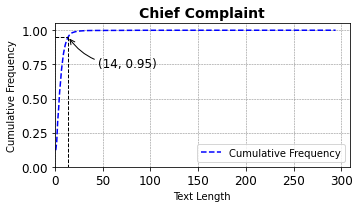

In [38]:
# Count the number of non-zero values in each row, i.e. the number converted to tokens. Then do the frequency accumulation graph
counts = np.count_nonzero(input_vec1, axis=1)
x0,x1,x2 = count_freq(col, counts)

In [39]:
input_vec1_cumF99 = input_vec1[:,:x0]
print(input_vec1_cumF99.shape)
input_vec1_cumF99

(5794, 23)


array([[462,   1,   7, ...,   0,   0,   0],
       [ 12,   1,  54, ...,   0,   0,   0],
       [  2,   1,  56, ...,   0,   0,   0],
       ...,
       [ 11,   1,   7, ...,   0,   0,   0],
       [ 14,  13,   0, ...,   0,   0,   0],
       [701, 146,  98, ...,   0,   0,   0]])

In [40]:
input_vec1_cumF95 = input_vec1[:,:x1]
print(input_vec1_cumF95.shape)
input_vec1_cumF95

(5794, 14)


array([[462,   1,   7, ...,   0,   0,   0],
       [ 12,   1,  54, ...,   0,   0,   0],
       [  2,   1,  56, ...,   0,   0,   0],
       ...,
       [ 11,   1,   7, ...,   0,   0,   0],
       [ 14,  13,   0, ...,   0,   0,   0],
       [701, 146,  98, ...,   0,   0,   0]])

In [41]:
input_vec1_cumF90 = input_vec1[:,:x2]
print(input_vec1_cumF90.shape)
input_vec1_cumF90

(5794, 12)


array([[462,   1,   7, ..., 690,  13,   0],
       [ 12,   1,  54, ...,  26,   0,   0],
       [  2,   1,  56, ...,   0,   0,   0],
       ...,
       [ 11,   1,   7, ...,  10, 139,   0],
       [ 14,  13,   0, ...,   0,   0,   0],
       [701, 146,  98, ...,   0,   0,   0]])

# 2. word2vec: icd_title

In [77]:
col = "icd_title"
sentences_maxlength = 2784

In [78]:
sentences = df2[col].fillna("").values.tolist()
encoding = tokenizer(sentences, 
                     add_special_tokens=False, 
                     return_tensors='tf', 
                     padding='max_length', 
                     truncation=True, 
                     max_length=sentences_maxlength)

input_ids = encoding['input_ids']
input_ids2 = input_ids.numpy()
print(input_ids2.shape)
input_ids2

(5795, 2784)


array([[21831,  5048, 14494, ...,     0,     0,     0],
       [12104, 16042,  4290, ...,     0,     0,     0],
       [12104,  1107, 11916, ...,     0,     0,     0],
       ...,
       [27323,  1104, 20003, ...,     0,     0,     0],
       [22832,   172, 25669, ...,     0,     0,     0],
       [ 1126, 20504,   117, ...,     0,     0,     0]])

最长的tokens为671个词汇或单词。


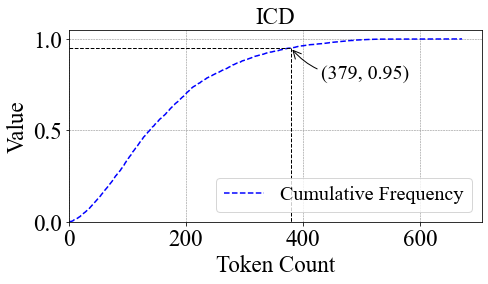

In [81]:
# Count the number of non-zero values in each row, i.e. the number converted to tokens. Then do the frequency accumulation graph
counts = np.count_nonzero(input_ids2, axis=1)
x0,x1,x2 = count_freq(col, counts)

In [45]:
input_ids2_cumF99 = input_ids2[:,:x0]
print(input_ids2_cumF99.shape)
input_ids2_cumF99

(5794, 477)


array([[ 8050, 23503,  1233, ...,     0,     0,     0],
       [14705,  9939,  1107, ...,     0,     0,     0],
       [12104,  9712, 15792, ...,     0,     0,     0],
       ...,
       [ 1404,  3367,  7448, ...,     0,     0,     0],
       [21831,  5048, 14494, ...,     0,     0,     0],
       [12104, 19192,  4290, ...,     0,     0,     0]])

In [46]:
input_ids2_cumF95 = input_ids2[:,:x1]
print(input_ids2_cumF95.shape)
input_ids2_cumF95

(5794, 379)


array([[ 8050, 23503,  1233, ...,     0,     0,     0],
       [14705,  9939,  1107, ...,     0,     0,     0],
       [12104,  9712, 15792, ...,     0,     0,     0],
       ...,
       [ 1404,  3367,  7448, ...,     0,     0,     0],
       [21831,  5048, 14494, ...,     0,     0,     0],
       [12104, 19192,  4290, ...,     0,     0,     0]])

In [47]:
input_ids2_cumF90 = input_ids2[:,:x2]
print(input_ids2_cumF90.shape)
input_ids2_cumF90

(5794, 314)


array([[ 8050, 23503,  1233, ...,     0,     0,     0],
       [14705,  9939,  1107, ...,     0,     0,     0],
       [12104,  9712, 15792, ...,     0,     0,     0],
       ...,
       [ 1404,  3367,  7448, ...,     0,     0,     0],
       [21831,  5048, 14494, ...,     0,     0,     0],
       [12104, 19192,  4290, ...,     0,     0,     0]])

In [61]:
# 2 Preparing word2vec for the LSTM

In [48]:
texts = df2[col].fillna("").values.tolist()
texts = add_space_around_punctuation(texts)
unique_words = set()

for text in texts:

    words = text.split()

    unique_words.update(words)

unique_word_count = len(unique_words)
print(f'There are {unique_word_count} unique words in the texts.')

There are 3804 unique words in the texts.


In [49]:
max_fatures = int(unique_word_count*1)
tokenizer2 = Tokenizer(num_words=max_fatures, filters='', split=' ')
tokenizer2.fit_on_texts(texts)

# texts to sequences
text_vec = tokenizer2.texts_to_sequences(texts)

input_vec2 = pad_sequences(text_vec, padding='post', maxlen=sentences_maxlength)
print(input_vec2.shape)
input_vec2

(5794, 2784)


array([[433, 556, 321, ...,   0,   0,   0],
       [257, 324,  14, ...,   0,   0,   0],
       [ 17,  84,   6, ...,   0,   0,   0],
       ...,
       [129, 148, 163, ...,   0,   0,   0],
       [ 42, 128,   1, ...,   0,   0,   0],
       [ 17,  77,  31, ...,   0,   0,   0]])

最长的tokens为451个词汇或单词。


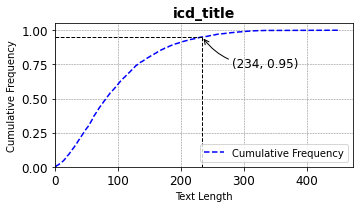

In [50]:
counts = np.count_nonzero(input_vec2, axis=1)
x0,x1,x2 = count_freq(col, counts)

In [51]:
input_vec2_cumF99 = input_vec2[:,:x0]
print(input_vec2_cumF99.shape)
input_vec2_cumF99

(5794, 301)


array([[433, 556, 321, ...,   0,   0,   0],
       [257, 324,  14, ...,   0,   0,   0],
       [ 17,  84,   6, ...,   0,   0,   0],
       ...,
       [129, 148, 163, ...,   0,   0,   0],
       [ 42, 128,   1, ...,   0,   0,   0],
       [ 17,  77,  31, ...,   0,   0,   0]])

In [52]:
input_vec2_cumF95 = input_vec2[:,:x1]
print(input_vec2_cumF95.shape)
input_vec2_cumF95

(5794, 234)


array([[433, 556, 321, ...,   0,   0,   0],
       [257, 324,  14, ...,   0,   0,   0],
       [ 17,  84,   6, ...,   0,   0,   0],
       ...,
       [129, 148, 163, ...,   0,   0,   0],
       [ 42, 128,   1, ...,   0,   0,   0],
       [ 17,  77,  31, ...,   0,   0,   0]])

In [53]:
input_vec2_cumF90 = input_vec2[:,:x2]
print(input_vec2_cumF90.shape)
input_vec2_cumF90

(5794, 192)


array([[433, 556, 321, ...,   0,   0,   0],
       [257, 324,  14, ...,   0,   0,   0],
       [ 17,  84,   6, ...,   0,   0,   0],
       ...,
       [129, 148, 163, ...,   0,   0,   0],
       [ 42, 128,   1, ...,   0,   0,   0],
       [ 17,  77,  31, ...,   0,   0,   0]])

# 3. word2vec: Allergies

In [82]:
col = "Allergies"
sentences_maxlength = 306

In [83]:
sentences = df2[col].fillna("").values.tolist()
encoding = tokenizer(sentences, 
                     add_special_tokens=False, 
                     return_tensors='tf', 
                     padding='max_length', 
                     truncation=True, 
                     max_length=sentences_maxlength)

input_ids = encoding['input_ids']
input_ids3 = input_ids.numpy()
print(input_ids3.shape)
input_ids3

(5795, 306)


array([[ 8228, 27989, 23824, ...,     0,     0,     0],
       [  184, 16844,  2528, ...,     0,     0,     0],
       [ 1185,  1227,  1155, ...,     0,     0,     0],
       ...,
       [ 8228, 27989, 23824, ...,     0,     0,     0],
       [ 1185,  1227,  1155, ...,     0,     0,     0],
       [ 1185,  1227,  1155, ...,     0,     0,     0]])

最长的tokens为114个词汇或单词。


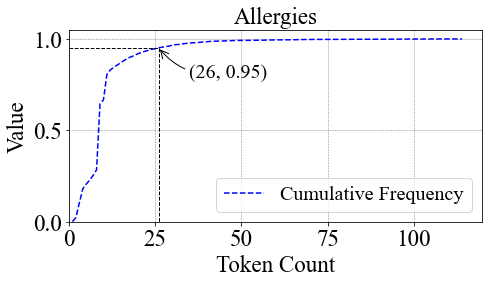

In [84]:
counts = np.count_nonzero(input_ids3, axis=1)
x0,x1,x2 = count_freq(col, counts)

In [57]:
input_ids3_cumF99 = input_ids3[:,:x0]
print(input_ids3_cumF99.shape)
input_ids3_cumF99

(5794, 47)


array([[  178,  1964, 23966, ...,     0,     0,     0],
       [ 1185,  1227,  1155, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       ...,
       [ 1185,  1227,  1155, ...,     0,     0,     0],
       [ 5351,  1802,  1112, ...,     0,     0,     0],
       [ 1185,  1227,  1155, ...,     0,     0,     0]])

In [58]:
input_ids3_cumF95 = input_ids3[:,:x1]
print(input_ids3_cumF95.shape)
input_ids3_cumF95

(5794, 26)


array([[  178,  1964, 23966, ...,     0,     0,     0],
       [ 1185,  1227,  1155, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       ...,
       [ 1185,  1227,  1155, ...,     0,     0,     0],
       [ 5351,  1802,  1112, ...,     0,     0,     0],
       [ 1185,  1227,  1155, ...,     0,     0,     0]])

In [59]:
input_ids3_cumF90 = input_ids3[:,:x2]
print(input_ids3_cumF90.shape)
input_ids3_cumF90

(5794, 18)


array([[  178,  1964, 23966, ...,     0,     0,     0],
       [ 1185,  1227,  1155, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       ...,
       [ 1185,  1227,  1155, ...,     0,     0,     0],
       [ 5351,  1802,  1112, ...,     0,     0,     0],
       [ 1185,  1227,  1155, ...,     0,     0,     0]])

In [60]:
# 2 为LSTM准备word2vec

In [61]:
texts = df2[col].fillna("").values.tolist()
texts = add_space_around_punctuation(texts)
unique_words = set()

for text in texts:
    words = text.split()
    unique_words.update(words)

unique_word_count = len(unique_words)
print(f'There are {unique_word_count} unique words in the texts.')

There are 1171 unique words in the texts.


In [62]:
max_fatures = int(unique_word_count*1)
tokenizer3 = Tokenizer(num_words=max_fatures, filters='', split=' ')
tokenizer3.fit_on_texts(texts)

# texts to sequences
text_vec = tokenizer3.texts_to_sequences(texts)

input_vec3 = pad_sequences(text_vec, padding='post', maxlen=sentences_maxlength)
print(input_vec3.shape)
input_vec3

(5794, 306)


array([[38, 36, 49, ...,  0,  0,  0],
       [ 3,  4,  2, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 3,  4,  2, ...,  0,  0,  0],
       [13,  8, 10, ...,  0,  0,  0],
       [ 3,  4,  2, ...,  0,  0,  0]])

最长的tokens为51个词汇或单词。


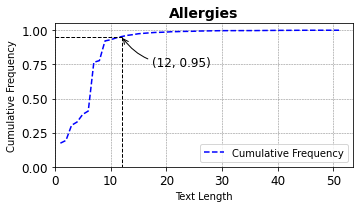

In [63]:
counts = np.count_nonzero(input_vec3, axis=1)
x0,x1,x2 = count_freq(col, counts)

In [64]:
input_vec3_cumF99 = input_vec3[:,:x0]
print(input_vec3_cumF99.shape)
input_vec3_cumF99

(5794, 23)


array([[38, 36, 49, ...,  0,  0,  0],
       [ 3,  4,  2, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 3,  4,  2, ...,  0,  0,  0],
       [13,  8, 10, ...,  0,  0,  0],
       [ 3,  4,  2, ...,  0,  0,  0]])

In [65]:
input_vec3_cumF95 = input_vec3[:,:x1]
print(input_vec3_cumF95.shape)
input_vec3_cumF95

(5794, 12)


array([[ 38,  36,  49, ..., 656,   0,   0],
       [  3,   4,   2, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  3,   4,   2, ...,   0,   0,   0],
       [ 13,   8,  10, ...,   0,   0,   0],
       [  3,   4,   2, ...,   0,   0,   0]])

In [66]:
input_vec3_cumF90 = input_vec3[:,:x2]
print(input_vec3_cumF90.shape)
input_vec3_cumF90

(5794, 9)


array([[ 38,  36,  49, ...,  44,   1, 655],
       [  3,   4,   2, ...,   7,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  3,   4,   2, ...,   7,   0,   0],
       [ 13,   8,  10, ...,   2,  11,   9],
       [  3,   4,   2, ...,   7,   0,   0]])

# 4. word2vec: History of Present Illness

In [85]:
col = "History of Present Illness"
sentences_maxlength = 10000

In [86]:
sentences = df2[col].fillna("").values.tolist()
encoding = tokenizer(sentences, 
                     add_special_tokens=False, 
                     return_tensors='tf', 
                     padding='max_length', 
                     truncation=True, 
                     max_length=sentences_maxlength)

input_ids = encoding['input_ids']
input_ids4 = input_ids.numpy()
print(input_ids4.shape)
input_ids4

(5795, 10000)


array([[ 182, 1733,  119, ...,    0,    0,    0],
       [ 168,  168,  168, ...,    0,    0,    0],
       [ 182, 1197,  119, ...,    0,    0,    0],
       ...,
       [ 168,  168,  168, ...,    0,    0,    0],
       [ 182, 1197,  119, ...,    0,    0,    0],
       [ 168,  168,  168, ...,    0,    0,    0]])

最长的tokens为3698个词汇或单词。


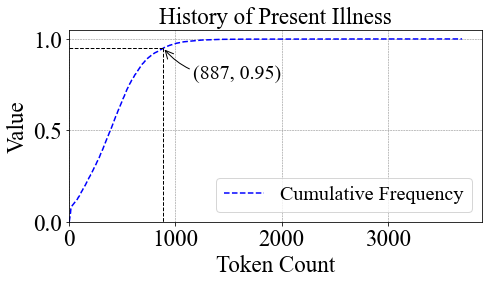

In [87]:
counts = np.count_nonzero(input_ids4, axis=1)
x0,x1,x2 = count_freq(col, counts)

In [70]:
input_ids4_cumF99 = input_ids4[:,:x0]
print(input_ids4_cumF99.shape)
input_ids4_cumF99

(5794, 1178)


array([[1142, 1110,  170, ...,    0,    0,    0],
       [ 168,  168,  168, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [5351, 1110,  170, ...,    0,    0,    0],
       [ 182, 1197,  119, ...,    0,    0,    0],
       [ 168,  168,  168, ...,    0,    0,    0]])

In [71]:
input_ids4_cumF95 = input_ids4[:,:x1]
print(input_ids4_cumF95.shape)
input_ids4_cumF95

(5794, 887)


array([[1142, 1110,  170, ...,    0,    0,    0],
       [ 168,  168,  168, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [5351, 1110,  170, ..., 1679, 6857, 1182],
       [ 182, 1197,  119, ...,    0,    0,    0],
       [ 168,  168,  168, ...,    0,    0,    0]])

In [72]:
input_ids4_cumF90 = input_ids4[:,:x2]
print(input_ids4_cumF90.shape)
input_ids4_cumF90

(5794, 752)


array([[ 1142,  1110,   170, ...,     0,     0,     0],
       [  168,   168,   168, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       ...,
       [ 5351,  1110,   170, ...,   172, 11470, 19091],
       [  182,  1197,   119, ...,     0,     0,     0],
       [  168,   168,   168, ...,     0,     0,     0]])

In [73]:
# 2 Preparing word2vec for the LSTM

In [74]:
texts = df2[col].fillna("").values.tolist()
texts = add_space_around_punctuation(texts)
unique_words = set()

for text in texts:

    words = text.split()
    unique_words.update(words)

unique_word_count = len(unique_words)
print(f'There are {unique_word_count} unique words in the texts.')

There are 24326 unique words in the texts.


In [75]:
max_fatures = int(unique_word_count*1) 
tokenizer4 = Tokenizer(num_words=max_fatures, filters='', split=' ')
tokenizer4.fit_on_texts(texts)

# texts to sequences
text_vec = tokenizer4.texts_to_sequences(texts)

input_vec4 = pad_sequences(text_vec, padding='post', maxlen=sentences_maxlength)
print(input_vec4.shape)
input_vec4

(5794, 10000)


array([[ 37,  20,  12, ...,   0,   0,   0],
       [  1,   1,   1, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [ 26,  20,  12, ...,   0,   0,   0],
       [170,   2,   1, ...,   0,   0,   0],
       [  1,   1,   1, ...,   0,   0,   0]])

最长的tokens为2873个词汇或单词。


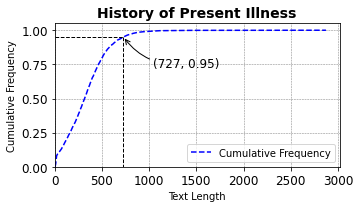

In [76]:
counts = np.count_nonzero(input_vec4, axis=1)
x0,x1,x2 = count_freq(col, counts)

In [77]:
input_vec4_cumF99 = input_vec4[:,:x0]
print(input_vec4_cumF99.shape)
input_vec4_cumF99

(5794, 959)


array([[ 37,  20,  12, ...,   0,   0,   0],
       [  1,   1,   1, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [ 26,  20,  12, ...,   0,   0,   0],
       [170,   2,   1, ...,   0,   0,   0],
       [  1,   1,   1, ...,   0,   0,   0]])

In [78]:
input_vec4_cumF95 = input_vec4[:,:x1]
print(input_vec4_cumF95.shape)
input_vec4_cumF95

(5794, 727)


array([[ 37,  20,  12, ...,   0,   0,   0],
       [  1,   1,   1, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [ 26,  20,  12, ...,   2,  30, 555],
       [170,   2,   1, ...,   0,   0,   0],
       [  1,   1,   1, ...,   0,   0,   0]])

In [79]:
input_vec4_cumF90 = input_vec4[:,:x2]
print(input_vec4_cumF90.shape)
input_vec4_cumF90

(5794, 618)


array([[  37,   20,   12, ...,    0,    0,    0],
       [   1,    1,    1, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [  26,   20,   12, ..., 1752,   16, 1205],
       [ 170,    2,    1, ...,    0,    0,    0],
       [   1,    1,    1, ...,    0,    0,    0]])

# 5. word2ver: Past Medical History

In [88]:
col = "Past Medical History"
sentences_maxlength = 9055

In [89]:
sentences = df2[col].fillna("").values.tolist()
encoding = tokenizer(sentences, 
                     add_special_tokens=False, 
                     return_tensors='tf', 
                     padding='max_length', 
                     truncation=True, 
                     max_length=sentences_maxlength)

input_ids = encoding['input_ids']
input_ids5 = input_ids.numpy()
print(input_ids5.shape)
input_ids5

(5795, 9055)


array([[ 2967,   188, 10536, ...,     0,     0,     0],
       [  122,   119, 21718, ...,     0,     0,     0],
       [20844,  6575,  1233, ...,     0,     0,     0],
       ...,
       [  118, 23078,  1228, ...,     0,     0,     0],
       [ 1763,  1113,  2528, ...,     0,     0,     0],
       [10468,  1329,  8936, ...,     0,     0,     0]])

最长的tokens为2643个词汇或单词。


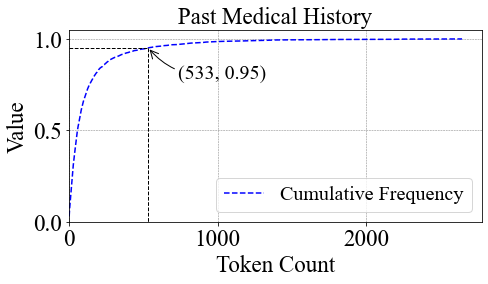

In [90]:
counts = np.count_nonzero(input_ids5, axis=1)
x0,x1,x2 = count_freq(col, counts)

In [83]:
input_ids5_cumF99 = input_ids5[:,:x0]
print(input_ids5_cumF99.shape)
input_ids5_cumF99

(5794, 1199)


array([[  118,   118, 27154, ...,     0,     0,     0],
       [ 2075,  7560,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       ...,
       [20844,  1964,   120, ...,     0,     0,     0],
       [  118,   183,  1116, ...,     0,     0,     0],
       [ 9852,  1324,  1775, ...,     0,     0,     0]])

In [84]:
input_ids5_cumF95 = input_ids5[:,:x1]
print(input_ids5_cumF95.shape)
input_ids5_cumF95

(5794, 533)


array([[  118,   118, 27154, ...,     0,     0,     0],
       [ 2075,  7560,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       ...,
       [20844,  1964,   120, ...,     0,     0,     0],
       [  118,   183,  1116, ...,     0,     0,     0],
       [ 9852,  1324,  1775, ...,     0,     0,     0]])

In [85]:
input_ids5_cumF90 = input_ids5[:,:x2]
print(input_ids5_cumF90.shape)
input_ids5_cumF90

(5794, 312)


array([[  118,   118, 27154, ...,     0,     0,     0],
       [ 2075,  7560,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       ...,
       [20844,  1964,   120, ...,     0,     0,     0],
       [  118,   183,  1116, ...,     0,     0,     0],
       [ 9852,  1324,  1775, ...,     0,     0,     0]])

In [86]:
# 2 Preparing word2vec for the LSTM

In [87]:
texts = df2[col].fillna("").values.tolist()
texts = add_space_around_punctuation(texts)

unique_words = set()

for text in texts:

    words = text.split()

    unique_words.update(words)

unique_word_count = len(unique_words)
print(f'There are {unique_word_count} unique words in the texts.')

There are 14357 unique words in the texts.


In [88]:
max_fatures = int(unique_word_count*1)
tokenizer5 = Tokenizer(num_words=max_fatures, filters='', split=' ')
tokenizer5.fit_on_texts(texts)

# texts to sequences
text_vec = tokenizer5.texts_to_sequences(texts)

input_vec5 = pad_sequences(text_vec, padding='post', maxlen=sentences_maxlength)
print(input_vec5.shape)
input_vec5

(5794, 9055)


array([[   2,    2,  181, ...,    0,    0,    0],
       [2580,   48,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [ 114,    5,  575, ...,    0,    0,    0],
       [   2, 2664,    9, ...,    0,    0,    0],
       [ 705,    8,  365, ...,    0,    0,    0]])

最长的tokens为1935个词汇或单词。


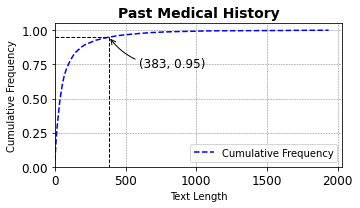

In [89]:
counts = np.count_nonzero(input_vec5, axis=1)
x0,x1,x2 = count_freq(col, counts)

In [90]:
input_vec5_cumF99 = input_vec5[:,:x0]
print(input_vec5_cumF99.shape)
input_vec5_cumF99

(5794, 870)


array([[   2,    2,  181, ...,    0,    0,    0],
       [2580,   48,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [ 114,    5,  575, ...,    0,    0,    0],
       [   2, 2664,    9, ...,    0,    0,    0],
       [ 705,    8,  365, ...,    0,    0,    0]])

In [91]:
input_vec5_cumF95 = input_vec5[:,:x1]
print(input_vec5_cumF95.shape)
input_vec5_cumF95

(5794, 383)


array([[   2,    2,  181, ...,    0,    0,    0],
       [2580,   48,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [ 114,    5,  575, ...,    0,    0,    0],
       [   2, 2664,    9, ...,    0,    0,    0],
       [ 705,    8,  365, ...,    0,    0,    0]])

In [92]:
input_vec5_cumF90 = input_vec5[:,:x2]
print(input_vec5_cumF90.shape)
input_vec5_cumF90

(5794, 226)


array([[   2,    2,  181, ...,    0,    0,    0],
       [2580,   48,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [ 114,    5,  575, ...,    0,    0,    0],
       [   2, 2664,    9, ...,    0,    0,    0],
       [ 705,    8,  365, ...,    0,    0,    0]])

# 6. word2vec: Family History

In [91]:
col = "Family History"
sentences_maxlength = 10000

In [92]:
sentences = df2[col].fillna("").values.tolist()
encoding = tokenizer(sentences, 
                     add_special_tokens=False, 
                     return_tensors='tf', 
                     padding='max_length', 
                     truncation=True, 
                     max_length=sentences_maxlength)

input_ids = encoding['input_ids']
input_ids6 = input_ids.numpy()
print(input_ids6.shape)
input_ids6

(5795, 10000)


array([[ 1534,  1114, 13316, ...,     0,     0,     0],
       [ 1534,   131,   168, ...,     0,     0,     0],
       [ 1119,  1144,  1185, ...,     0,     0,     0],
       ...,
       [ 1401,  1452,  1104, ...,     0,     0,     0],
       [ 1401,  1125,  5250, ...,     0,     0,     0],
       [  118,  1632,  7502, ...,     0,     0,     0]])

最长的tokens为8265个词汇或单词。


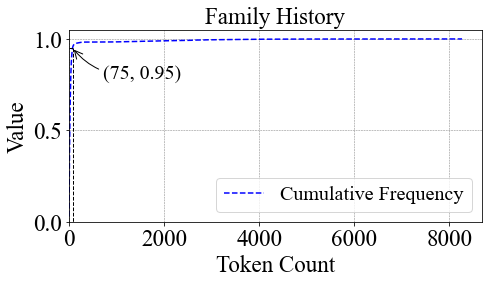

In [93]:
counts = np.count_nonzero(input_ids6, axis=1)
x0,x1,x2 = count_freq(col, counts)

In [96]:
input_ids6_cumF99 = input_ids6[:,:x0]
print(input_ids6_cumF99.shape)
input_ids6_cumF99

(5794, 2202)


array([[1117, 1266, 1607, ...,    0,    0,    0],
       [1534, 1452, 1104, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [7815,  117, 3655, ...,    0,    0,    0],
       [ 116,  173, 1306, ...,    0,    0,    0],
       [1266,  177, 1775, ...,    0,    0,    0]])

In [97]:
input_ids6_cumF95 = input_ids6[:,:x1]
print(input_ids6_cumF95.shape)
input_ids6_cumF95

(5794, 75)


array([[1117, 1266, 1607, ...,    0,    0,    0],
       [1534, 1452, 1104, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [7815,  117, 3655, ...,    0,    0,    0],
       [ 116,  173, 1306, ...,    0,    0,    0],
       [1266,  177, 1775, ...,    0,    0,    0]])

In [98]:
input_ids6_cumF90 = input_ids6[:,:x2]
print(input_ids6_cumF90.shape)
input_ids6_cumF90

(5794, 56)


array([[1117, 1266, 1607, ...,    0,    0,    0],
       [1534, 1452, 1104, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [7815,  117, 3655, ...,    0,    0,    0],
       [ 116,  173, 1306, ...,    0,    0,    0],
       [1266,  177, 1775, ...,    0,    0,    0]])

In [87]:
# 2 Preparing word2vec for the LSTM

In [99]:
texts = df2[col].fillna("").values.tolist()
texts = add_space_around_punctuation(texts)

unique_words = set()

for text in texts:
    words = text.split()
    unique_words.update(words)

unique_word_count = len(unique_words)
print(f'There are {unique_word_count} unique words in the texts.')

There are 9336 unique words in the texts.


In [100]:
max_fatures = int(unique_word_count*1)
tokenizer6 = Tokenizer(num_words=max_fatures, filters='', split=' ')
tokenizer6.fit_on_texts(texts)

# texts to sequences
text_vec = tokenizer6.texts_to_sequences(texts)

input_vec6 = pad_sequences(text_vec, padding='post', maxlen=sentences_maxlength)
print(input_vec6.shape)
input_vec6

(5794, 10000)


array([[ 41,  25,  20, ...,   0,   0,   0],
       [ 14,  26,   6, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [611,   4,  78, ...,   0,   0,   0],
       [ 93,  72,  12, ...,   0,   0,   0],
       [ 25, 134,   5, ...,   0,   0,   0]])

最长的tokens为6347个词汇或单词。


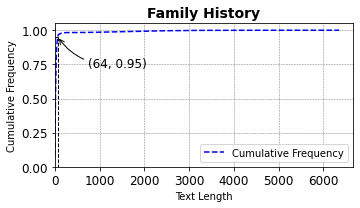

In [101]:
counts = np.count_nonzero(input_vec6, axis=1)
x0,x1,x2 = count_freq(col, counts)

In [102]:
input_vec6_cumF99 = input_vec6[:,:x0]
print(input_vec6_cumF99.shape)
input_vec6_cumF99

(5794, 1637)


array([[ 41,  25,  20, ...,   0,   0,   0],
       [ 14,  26,   6, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [611,   4,  78, ...,   0,   0,   0],
       [ 93,  72,  12, ...,   0,   0,   0],
       [ 25, 134,   5, ...,   0,   0,   0]])

In [103]:
input_vec6_cumF95 = input_vec6[:,:x1]
print(input_vec6_cumF95.shape)
input_vec6_cumF95

(5794, 64)


array([[ 41,  25,  20, ...,   0,   0,   0],
       [ 14,  26,   6, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [611,   4,  78, ...,   0,   0,   0],
       [ 93,  72,  12, ...,   0,   0,   0],
       [ 25, 134,   5, ...,   0,   0,   0]])

In [104]:
input_vec6_cumF90 = input_vec6[:,:x2]
print(input_vec6_cumF90.shape)
input_vec6_cumF90

(5794, 47)


array([[ 41,  25,  20, ...,   0,   0,   0],
       [ 14,  26,   6, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [611,   4,  78, ...,   0,   0,   0],
       [ 93,  72,  12, ...,   0,   0,   0],
       [ 25, 134,   5, ...,   0,   0,   0]])

# Merge Chief Complaint

In [107]:
labels = df2[['hospital_expire_flag']]
labels

,hospital_expire_flag
0,0
1,0
2,0
3,0
4,1
...,...
5789,0
5790,0
5791,0
5792,0


In [108]:
Bert_ChiefComplaint99 = np.concatenate([input_ids1_cumF99,labels], axis=1)
print(Bert_ChiefComplaint99.shape)
pd.DataFrame(Bert_ChiefComplaint99).to_csv("E:/CNSI_project/demo_and_data_5.0/Processed_data/MIMIC/aim2_merged_VecData/Bert_ChiefComplaint99.csv",index=False)
Bert_ChiefComplaint99

(5794, 32)


array([[ 1260,  7889,  7412, ...,     0,     0,     0],
       [ 4036,   117, 21718, ...,     0,     0,     0],
       [16320,   117,  5173, ...,     0,     0,     0],
       ...,
       [10880,   117, 11477, ...,     0,     0,     0],
       [20752,   119,     0, ...,     0,     0,     0],
       [  170,  8178,  1126, ...,     0,     0,     1]], dtype=int64)

In [109]:
Bert_ChiefComplaint95 = np.concatenate([input_ids1_cumF95,labels], axis=1)
print(Bert_ChiefComplaint95.shape)
pd.DataFrame(Bert_ChiefComplaint95).to_csv("E:/CNSI_project/demo_and_data_5.0/Processed_data/MIMIC/aim2_merged_VecData/Bert_ChiefComplaint95.csv",index=False)
Bert_ChiefComplaint95

(5794, 21)


array([[ 1260,  7889,  7412, ...,     0,     0,     0],
       [ 4036,   117, 21718, ...,     0,     0,     0],
       [16320,   117,  5173, ...,     0,     0,     0],
       ...,
       [10880,   117, 11477, ...,     0,     0,     0],
       [20752,   119,     0, ...,     0,     0,     0],
       [  170,  8178,  1126, ...,     0,     0,     1]], dtype=int64)

In [110]:
Bert_ChiefComplaint90 = np.concatenate([input_ids1_cumF90,labels], axis=1)
print(Bert_ChiefComplaint90.shape)
pd.DataFrame(Bert_ChiefComplaint90).to_csv("E:/CNSI_project/demo_and_data_5.0/Processed_data/MIMIC/aim2_merged_VecData/Bert_ChiefComplaint90.csv",index=False)
Bert_ChiefComplaint90

(5794, 17)


array([[ 1260,  7889,  7412, ...,  1610, 16430,     0],
       [ 4036,   117, 21718, ...,     0,     0,     0],
       [16320,   117,  5173, ...,     0,     0,     0],
       ...,
       [10880,   117, 11477, ..., 23610,     0,     0],
       [20752,   119,     0, ...,     0,     0,     0],
       [  170,  8178,  1126, ...,     0,     0,     1]], dtype=int64)

In [111]:
# 用keras生成的vec，且概率累积在.99的长度
Keras_ChiefComplaint99 = np.concatenate([input_vec1_cumF99,labels], axis=1)
print(Keras_ChiefComplaint99.shape)
pd.DataFrame(Keras_ChiefComplaint99).to_csv("E:/CNSI_project/demo_and_data_5.0/Processed_data/MIMIC/aim2_merged_VecData/Keras_ChiefComplaint99.csv",index=False)
Keras_ChiefComplaint99

(5794, 24)


array([[462,   1,   7, ...,   0,   0,   0],
       [ 12,   1,  54, ...,   0,   0,   0],
       [  2,   1,  56, ...,   0,   0,   0],
       ...,
       [ 11,   1,   7, ...,   0,   0,   0],
       [ 14,  13,   0, ...,   0,   0,   0],
       [701, 146,  98, ...,   0,   0,   1]], dtype=int64)

In [112]:
Keras_ChiefComplaint95 = np.concatenate([input_vec1_cumF95,labels], axis=1)
print(Keras_ChiefComplaint95.shape)
pd.DataFrame(Keras_ChiefComplaint95).to_csv("E:/CNSI_project/demo_and_data_5.0/Processed_data/MIMIC/aim2_merged_VecData/Keras_ChiefComplaint95.csv",index=False)
Keras_ChiefComplaint95

(5794, 15)


array([[462,   1,   7, ...,   0,   0,   0],
       [ 12,   1,  54, ...,   0,   0,   0],
       [  2,   1,  56, ...,   0,   0,   0],
       ...,
       [ 11,   1,   7, ...,   0,   0,   0],
       [ 14,  13,   0, ...,   0,   0,   0],
       [701, 146,  98, ...,   0,   0,   1]], dtype=int64)

In [113]:
Keras_ChiefComplaint90 = np.concatenate([input_vec1_cumF90,labels], axis=1)
print(Keras_ChiefComplaint90.shape)
pd.DataFrame(Keras_ChiefComplaint90).to_csv("E:/CNSI_project/demo_and_data_5.0/Processed_data/MIMIC/aim2_merged_VecData/Keras_ChiefComplaint90.csv",index=False)
Keras_ChiefComplaint90

(5794, 13)


array([[462,   1,   7, ...,  13,   0,   0],
       [ 12,   1,  54, ...,   0,   0,   0],
       [  2,   1,  56, ...,   0,   0,   0],
       ...,
       [ 11,   1,   7, ..., 139,   0,   0],
       [ 14,  13,   0, ...,   0,   0,   0],
       [701, 146,  98, ...,   0,   0,   1]], dtype=int64)

# Merge All six

In [114]:
# vec generated with bert and with probability cumulative at length .99
Bert_All99 = np.concatenate([input_ids1_cumF99,
                             input_ids2_cumF99,
                             input_ids3_cumF99,
                             input_ids4_cumF99,
                             input_ids5_cumF99,
                             input_ids6_cumF99,
                             labels], axis=1)
print(Bert_All99.shape)
pd.DataFrame(Bert_All99).to_csv("E:/CNSI_project/demo_and_data_5.0/Processed_data/MIMIC/aim2_merged_VecData/Bert_All99.csv",index=False)
Bert_All99

(5794, 5135)


array([[ 1260,  7889,  7412, ...,     0,     0,     0],
       [ 4036,   117, 21718, ...,     0,     0,     0],
       [16320,   117,  5173, ...,     0,     0,     0],
       ...,
       [10880,   117, 11477, ...,     0,     0,     0],
       [20752,   119,     0, ...,     0,     0,     0],
       [  170,  8178,  1126, ...,     0,     0,     1]], dtype=int64)

In [115]:
Bert_All95 = np.concatenate([input_ids1_cumF95,
                             input_ids2_cumF95,
                             input_ids3_cumF95,
                             input_ids4_cumF95,
                             input_ids5_cumF95,
                             input_ids6_cumF95,
                             labels], axis=1)
print(Bert_All95.shape)
pd.DataFrame(Bert_All95).to_csv("E:/CNSI_project/demo_and_data_5.0/Processed_data/MIMIC/aim2_merged_VecData/Bert_All95.csv",index=False)
Bert_All95

(5794, 1921)


array([[ 1260,  7889,  7412, ...,     0,     0,     0],
       [ 4036,   117, 21718, ...,     0,     0,     0],
       [16320,   117,  5173, ...,     0,     0,     0],
       ...,
       [10880,   117, 11477, ...,     0,     0,     0],
       [20752,   119,     0, ...,     0,     0,     0],
       [  170,  8178,  1126, ...,     0,     0,     1]], dtype=int64)

In [116]:
Bert_All90 = np.concatenate([input_ids1_cumF90,
                             input_ids2_cumF90,
                             input_ids3_cumF90,
                             input_ids4_cumF90,
                             input_ids5_cumF90,
                             input_ids6_cumF90,
                             labels], axis=1)
print(Bert_All90.shape)
pd.DataFrame(Bert_All90).to_csv("E:/CNSI_project/demo_and_data_5.0/Processed_data/MIMIC/aim2_merged_VecData/Bert_All90.csv",index=False)
Bert_All90

(5794, 1469)


array([[ 1260,  7889,  7412, ...,     0,     0,     0],
       [ 4036,   117, 21718, ...,     0,     0,     0],
       [16320,   117,  5173, ...,     0,     0,     0],
       ...,
       [10880,   117, 11477, ...,     0,     0,     0],
       [20752,   119,     0, ...,     0,     0,     0],
       [  170,  8178,  1126, ...,     0,     0,     1]], dtype=int64)

In [117]:
# vec generated with keras with probability cumulative in .99 lengths
Keras_All99 = np.concatenate([input_vec1_cumF99,
                             input_vec2_cumF99,
                             input_vec3_cumF99,
                             input_vec4_cumF99,
                             input_vec5_cumF99,
                             input_vec6_cumF99,
                             labels], axis=1)
print(Keras_All99.shape)
pd.DataFrame(Keras_All99).to_csv("E:/CNSI_project/demo_and_data_5.0/Processed_data/MIMIC/aim2_merged_VecData/Keras_All99.csv",index=False)
Keras_All99

(5794, 3814)


array([[462,   1,   7, ...,   0,   0,   0],
       [ 12,   1,  54, ...,   0,   0,   0],
       [  2,   1,  56, ...,   0,   0,   0],
       ...,
       [ 11,   1,   7, ...,   0,   0,   0],
       [ 14,  13,   0, ...,   0,   0,   0],
       [701, 146,  98, ...,   0,   0,   1]], dtype=int64)

In [118]:
Keras_All95 = np.concatenate([input_vec1_cumF95,
                             input_vec2_cumF95,
                             input_vec3_cumF95,
                             input_vec4_cumF95,
                             input_vec5_cumF95,
                             input_vec6_cumF95,
                             labels], axis=1)
print(Keras_All95.shape)
pd.DataFrame(Keras_All95).to_csv("E:/CNSI_project/demo_and_data_5.0/Processed_data/MIMIC/aim2_merged_VecData/Keras_All95.csv",index=False)
Keras_All95

(5794, 1435)


array([[462,   1,   7, ...,   0,   0,   0],
       [ 12,   1,  54, ...,   0,   0,   0],
       [  2,   1,  56, ...,   0,   0,   0],
       ...,
       [ 11,   1,   7, ...,   0,   0,   0],
       [ 14,  13,   0, ...,   0,   0,   0],
       [701, 146,  98, ...,   0,   0,   1]], dtype=int64)

In [119]:
Keras_All90 = np.concatenate([input_vec1_cumF90,
                             input_vec2_cumF90,
                             input_vec3_cumF90,
                             input_vec4_cumF90,
                             input_vec5_cumF90,
                             input_vec6_cumF90,
                             labels], axis=1)
print(Keras_All90.shape)
pd.DataFrame(Keras_All90).to_csv("E:/CNSI_project/demo_and_data_5.0/Processed_data/MIMIC/aim2_merged_VecData/Keras_All90.csv",index=False)
Keras_All90

(5794, 1105)


array([[462,   1,   7, ...,   0,   0,   0],
       [ 12,   1,  54, ...,   0,   0,   0],
       [  2,   1,  56, ...,   0,   0,   0],
       ...,
       [ 11,   1,   7, ...,   0,   0,   0],
       [ 14,  13,   0, ...,   0,   0,   0],
       [701, 146,  98, ...,   0,   0,   1]], dtype=int64)

# Merge ChiefComplaint with each in 95

## 1. with icd_title

In [120]:
# bert
Bert_ChiefComplaint_with_ICD_95 = np.concatenate([input_ids1_cumF95,
                             input_ids2_cumF95,
                             labels], axis=1)
print(Bert_ChiefComplaint_with_ICD_95.shape)
pd.DataFrame(Bert_ChiefComplaint_with_ICD_95).to_csv("E:/CNSI_project/demo_and_data_5.0/Processed_data/MIMIC/aim2_merged_VecData/Bert_ChiefComplaint_with_ICD_95.csv",index=False)
Bert_ChiefComplaint_with_ICD_95

(5794, 400)


array([[ 1260,  7889,  7412, ...,     0,     0,     0],
       [ 4036,   117, 21718, ...,     0,     0,     0],
       [16320,   117,  5173, ...,     0,     0,     0],
       ...,
       [10880,   117, 11477, ...,     0,     0,     0],
       [20752,   119,     0, ...,     0,     0,     0],
       [  170,  8178,  1126, ...,     0,     0,     1]], dtype=int64)

In [121]:
# keras
Keras_ChiefComplaint_with_ICD_95 = np.concatenate([input_vec1_cumF95,
                             input_vec2_cumF95,
                             labels], axis=1)
print(Keras_ChiefComplaint_with_ICD_95.shape)
pd.DataFrame(Keras_ChiefComplaint_with_ICD_95).to_csv("E:/CNSI_project/demo_and_data_5.0/Processed_data/MIMIC/aim2_merged_VecData/Keras_ChiefComplaint_with_ICD_95.csv",index=False)
Keras_ChiefComplaint_with_ICD_95

(5794, 249)


array([[462,   1,   7, ...,   0,   0,   0],
       [ 12,   1,  54, ...,   0,   0,   0],
       [  2,   1,  56, ...,   0,   0,   0],
       ...,
       [ 11,   1,   7, ...,   0,   0,   0],
       [ 14,  13,   0, ...,   0,   0,   0],
       [701, 146,  98, ...,   0,   0,   1]], dtype=int64)

## 2. with Allergies

In [122]:
# bert
Bert_ChiefComplaint_with_Allergies_95 = np.concatenate([input_ids1_cumF95,
                             input_ids3_cumF95,
                             labels], axis=1)
print(Bert_ChiefComplaint_with_Allergies_95.shape)
pd.DataFrame(Bert_ChiefComplaint_with_Allergies_95).to_csv("E:/CNSI_project/demo_and_data_5.0/Processed_data/MIMIC/aim2_merged_VecData/Bert_ChiefComplaint_with_Allergies_95.csv",index=False)
Bert_ChiefComplaint_with_Allergies_95

(5794, 47)


array([[ 1260,  7889,  7412, ...,     0,     0,     0],
       [ 4036,   117, 21718, ...,     0,     0,     0],
       [16320,   117,  5173, ...,     0,     0,     0],
       ...,
       [10880,   117, 11477, ...,     0,     0,     0],
       [20752,   119,     0, ...,     0,     0,     0],
       [  170,  8178,  1126, ...,     0,     0,     1]], dtype=int64)

In [123]:
# keras
Keras_ChiefComplaint_with_Allergies_95 = np.concatenate([input_vec1_cumF95,
                             input_vec3_cumF95,
                             labels], axis=1)
print(Keras_ChiefComplaint_with_Allergies_95.shape)
pd.DataFrame(Keras_ChiefComplaint_with_Allergies_95).to_csv("E:/CNSI_project/demo_and_data_5.0/Processed_data/MIMIC/aim2_merged_VecData/Keras_ChiefComplaint_with_Allergies_95.csv",index=False)
Keras_ChiefComplaint_with_Allergies_95

(5794, 27)


array([[462,   1,   7, ...,   0,   0,   0],
       [ 12,   1,  54, ...,   0,   0,   0],
       [  2,   1,  56, ...,   0,   0,   0],
       ...,
       [ 11,   1,   7, ...,   0,   0,   0],
       [ 14,  13,   0, ...,   0,   0,   0],
       [701, 146,  98, ...,   0,   0,   1]], dtype=int64)

## 3. with History of Present Illness

In [124]:
# bert
Bert_ChiefComplaint_with_IllnessHistory_95 = np.concatenate([input_ids1_cumF95,
                             input_ids4_cumF95,
                             labels], axis=1)
print(Bert_ChiefComplaint_with_IllnessHistory_95.shape)
pd.DataFrame(Bert_ChiefComplaint_with_IllnessHistory_95).to_csv("E:/CNSI_project/demo_and_data_5.0/Processed_data/MIMIC/aim2_merged_VecData/Bert_ChiefComplaint_with_IllnessHistory_95.csv",index=False)
Bert_ChiefComplaint_with_IllnessHistory_95

(5794, 908)


array([[ 1260,  7889,  7412, ...,     0,     0,     0],
       [ 4036,   117, 21718, ...,     0,     0,     0],
       [16320,   117,  5173, ...,     0,     0,     0],
       ...,
       [10880,   117, 11477, ...,  6857,  1182,     0],
       [20752,   119,     0, ...,     0,     0,     0],
       [  170,  8178,  1126, ...,     0,     0,     1]], dtype=int64)

In [125]:
# keras
Keras_ChiefComplaint_with_IllnessHistory_95 = np.concatenate([input_vec1_cumF95,
                             input_vec4_cumF95,
                             labels], axis=1)
print(Keras_ChiefComplaint_with_IllnessHistory_95.shape)
pd.DataFrame(Keras_ChiefComplaint_with_IllnessHistory_95).to_csv("E:/CNSI_project/demo_and_data_5.0/Processed_data/MIMIC/aim2_merged_VecData/Keras_ChiefComplaint_with_IllnessHistory_95.csv",index=False)
Keras_ChiefComplaint_with_IllnessHistory_95

(5794, 742)


array([[462,   1,   7, ...,   0,   0,   0],
       [ 12,   1,  54, ...,   0,   0,   0],
       [  2,   1,  56, ...,   0,   0,   0],
       ...,
       [ 11,   1,   7, ...,  30, 555,   0],
       [ 14,  13,   0, ...,   0,   0,   0],
       [701, 146,  98, ...,   0,   0,   1]], dtype=int64)

## 4. with Past Medical History

In [126]:
# bert
Bert_ChiefComplaint_with_MedicalHistory_95 = np.concatenate([input_ids1_cumF95,
                             input_ids5_cumF95,
                             labels], axis=1)
print(Bert_ChiefComplaint_with_MedicalHistory_95.shape)
pd.DataFrame(Bert_ChiefComplaint_with_MedicalHistory_95).to_csv("E:/CNSI_project/demo_and_data_5.0/Processed_data/MIMIC/aim2_merged_VecData/Bert_ChiefComplaint_with_MedicalHistory_95.csv",index=False)
Bert_ChiefComplaint_with_MedicalHistory_95

(5794, 554)


array([[ 1260,  7889,  7412, ...,     0,     0,     0],
       [ 4036,   117, 21718, ...,     0,     0,     0],
       [16320,   117,  5173, ...,     0,     0,     0],
       ...,
       [10880,   117, 11477, ...,     0,     0,     0],
       [20752,   119,     0, ...,     0,     0,     0],
       [  170,  8178,  1126, ...,     0,     0,     1]], dtype=int64)

In [127]:
# keras
Keras_ChiefComplaint_with_MedicalHistory_95 = np.concatenate([input_vec1_cumF95,
                             input_vec5_cumF95,
                             labels], axis=1)
print(Keras_ChiefComplaint_with_MedicalHistory_95.shape)
pd.DataFrame(Keras_ChiefComplaint_with_MedicalHistory_95).to_csv("E:/CNSI_project/demo_and_data_5.0/Processed_data/MIMIC/aim2_merged_VecData/Keras_ChiefComplaint_with_MedicalHistory_95.csv",index=False)
Keras_ChiefComplaint_with_MedicalHistory_95

(5794, 398)


array([[462,   1,   7, ...,   0,   0,   0],
       [ 12,   1,  54, ...,   0,   0,   0],
       [  2,   1,  56, ...,   0,   0,   0],
       ...,
       [ 11,   1,   7, ...,   0,   0,   0],
       [ 14,  13,   0, ...,   0,   0,   0],
       [701, 146,  98, ...,   0,   0,   1]], dtype=int64)

## 5. with Family History

In [128]:
# bert
Bert_ChiefComplaint_with_FamilyHistory_95 = np.concatenate([input_ids1_cumF95,
                             input_ids6_cumF95,
                             labels], axis=1)
print(Bert_ChiefComplaint_with_FamilyHistory_95.shape)
pd.DataFrame(Bert_ChiefComplaint_with_FamilyHistory_95).to_csv("E:/CNSI_project/demo_and_data_5.0/Processed_data/MIMIC/aim2_merged_VecData/Bert_ChiefComplaint_with_FamilyHistory_95.csv",index=False)
Bert_ChiefComplaint_with_FamilyHistory_95

(5794, 96)


array([[ 1260,  7889,  7412, ...,     0,     0,     0],
       [ 4036,   117, 21718, ...,     0,     0,     0],
       [16320,   117,  5173, ...,     0,     0,     0],
       ...,
       [10880,   117, 11477, ...,     0,     0,     0],
       [20752,   119,     0, ...,     0,     0,     0],
       [  170,  8178,  1126, ...,     0,     0,     1]], dtype=int64)

In [129]:
# keras
Keras_ChiefComplaint_with_FamilyHistory_95 = np.concatenate([input_vec1_cumF95,
                             input_vec6_cumF95,
                             labels], axis=1)
print(Keras_ChiefComplaint_with_FamilyHistory_95.shape)
pd.DataFrame(Keras_ChiefComplaint_with_FamilyHistory_95).to_csv("E:/CNSI_project/demo_and_data_5.0/Processed_data/MIMIC/aim2_merged_VecData/Keras_ChiefComplaint_with_FamilyHistory_95.csv",index=False)
Keras_ChiefComplaint_with_FamilyHistory_95

(5794, 79)


array([[462,   1,   7, ...,   0,   0,   0],
       [ 12,   1,  54, ...,   0,   0,   0],
       [  2,   1,  56, ...,   0,   0,   0],
       ...,
       [ 11,   1,   7, ...,   0,   0,   0],
       [ 14,  13,   0, ...,   0,   0,   0],
       [701, 146,  98, ...,   0,   0,   1]], dtype=int64)